In [60]:
%load_ext autoreload
%autoreload 2

import os
os.environ["GEOMSTATS_BACKEND"] = 'jax'
# os.environ["CUDA_VISIBLE_DEVICE"] = '6'
import setGPU

import math
import jax
import numpy as np
import jax.numpy as jnp
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline  

import geomstats
import geomstats.backend as gs
from score_sde.utils import GlobalRNG
from riemannian_score_sde.sde import Brownian

from geomstats.geometry.special_orthogonal import SpecialOrthogonal, _SpecialOrthogonal3Vectors
from geomstats.algebra_utils import from_vector_to_diagonal_matrix 
from riemannian_score_sde.datasets import Uniform, Wrapped, Langevin
from score_sde.utils.vis import plot_so3
from scipy.stats import special_ortho_group

g_rng = GlobalRNG()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
manifold = SpecialOrthogonal(n=3, point_type="matrix")

In [65]:
distribution = Wrapped(scale=0.2, K=4, batch_dims=(10), manifold=manifold, seed=0)
Q = next(distribution)
print(Q.shape)

(10, 3, 3)


In [59]:
# distribution = Langevin(beta=10, k=4, batch_dims=(10), manifold=manifold, seed=0)
# Q = next(distribution)

K=4
batch_dims=(512)
rng = jax.random.PRNGKey(0)
rng, next_key = jax.random.split(rng)

mean = manifold.random_uniform(state=next_key, n_samples=K)
rng, next_rng = jax.random.split(rng)
rng = rng
n_samples=np.prod(batch_dims)

cond = jnp.zeros((n_samples))
samples = jnp.zeros((n_samples, manifold.n, manifold.n))

_, C = gs.random.choice(state=next_rng, a=mean, n=n_samples)
C_tr = gs.transpose(C, axes=(0, 2, 1))
_, D, _ = jnp.linalg.svd(C)
D = from_vector_to_diagonal_matrix(D)

while not cond.all():
    X = manifold.random_uniform(state=next_rng, n_samples=n_samples)
    thresh = gs.exp(gs.trace(C_tr @ X - D, axis1=1, axis2=2))
    rng, next_rng = jax.random.split(rng)
    _, u = gs.random.rand(state=next_rng, size=n_samples)
    mask = u < thresh
    mask = gs.expand_dims(mask, axis=(-1, -2))
    samples = (1 - mask) * samples + mask * X
    cond = (1 - mask) * cond + mask * mask

# cond = jnp.zeros((1))
# samples = jnp.zeros((n_samples, manifold.n, manifold.n))

# for i in  range(n_samples):
#     rng, next_rng = jax.random.split(rng)
#     _, C = gs.random.choice(state=next_rng, a=mean, n=1)
#     C = gs.expand_dims(C, axis=0)
#     print('C', C.shape)
#     C_tr = gs.transpose(C, axes=(0, 2, 1))
#     print('C_tr', C_tr.shape)
#     _, D, _ = jnp.linalg.svd(C)
#     print('D', D.shape)
#     D = from_vector_to_diagonal_matrix(D)
#     print('D', D.shape)

#     while not cond.all():
#         print('while')
#         X = manifold.random_uniform(state=next_rng, n_samples=1)
#         print('X', X.shape)
#         thresh = gs.exp(gs.trace(C_tr @ X - D, axis1=1, axis2=2))
#         print('thresh', thresh.shape)
#         rng, next_rng = jax.random.split(rng)
#         _, u = gs.random.rand(state=next_rng, size=1)
#         print('u', u.shape)
#         print(u, thresh)
#         cond = u < thresh
#         # samples = samples.at[cond].set(X[cond])

        

step 0.099609375 0.0
step 0.095703125 0.099609375
step 0.103515625 0.1875
step 0.08984375 0.27539062
step 0.107421875 0.34765625
step 0.099609375 0.41796875
step 0.1171875 0.4765625
step 0.09375 0.52734375
step 0.0859375 0.5703125
step 0.0703125 0.6113281
step 0.083984375 0.6308594
step 0.09375 0.66796875
step 0.103515625 0.69140625
step 0.09375 0.7285156
step 0.080078125 0.7558594
step 0.111328125 0.765625
step 0.091796875 0.7910156
step 0.083984375 0.81640625
step 0.087890625 0.828125
step 0.09765625 0.83984375
step 0.080078125 0.859375
step 0.083984375 0.8808594
step 0.08984375 0.890625
step 0.0859375 0.8964844
step 0.078125 0.9042969
step 0.09375 0.9160156
step 0.1171875 0.9316406
step 0.083984375 0.9375
step 0.1015625 0.9433594
step 0.095703125 0.94921875
step 0.06640625 0.9589844
step 0.125 0.9628906
step 0.083984375 0.96484375
step 0.11328125 0.96484375
step 0.10546875 0.97265625
step 0.095703125 0.97265625
step 0.083984375 0.9746094
step 0.095703125 0.9765625
step 0.087890625 0

In [3]:
# target_distribution = Uniform(batch_dims=(2), manifold=manifold, seed=0)
# x = next(target_distribution)
# print(manifold.belongs(x, atol=1e-6).mean().item())
# z = next(target_distribution)
# z = manifold.identity
# print('x', x.shape)
# # print(x)

# rng = jax.random.PRNGKey(0)
# rng, next_key = jax.random.split(rng)
# v = manifold.random_normal_tangent(state=rng, base_point=x, n_samples=x.shape[0])[1]
# print('v', v.shape)

# # skew_matrix = manifold.log_from_identity(x)
# skew_matrix = manifold.log(x, z)
# # print('rot_vec', rot_vec.shape)
# # print(rot_vec)
# # skew_matrix = manifold.skew_matrix_from_vector(rot_vec)
# # print(gs.isclose(rot_vec, manifold.vector_from_skew_matrix(skew_matrix)).all())
# # y = manifold.exp_from_identity(skew_matrix)
# y = manifold.exp(skew_matrix, z)
# yb = gs.linalg.expm(skew_matrix)
# print('y', y.shape)
# # print(y)
# print(gs.isclose(x, y, atol=1e-4).all())
# print(gs.isclose(yb, y, atol=1e-4).all())


# angles = _SpecialOrthogonal3Vectors().tait_bryan_angles_from_matrix(x)
# print('angles', angles.shape, angles)
# xb = _SpecialOrthogonal3Vectors().matrix_from_tait_bryan_angles(angles)
# print(gs.isclose(x, xb, atol=1e-3).all())

In [4]:
B = 2**12
x0 = manifold.identity
angles = jnp.array([-math.pi/4, 0., 0.])
x0 = _SpecialOrthogonal3Vectors().matrix_from_tait_bryan_angles(angles)
print(x0)
x0 = next(Uniform(batch_dims=(1), manifold=manifold, seed=0))
x = next(Wrapped(mean=x0, scale=0.2, batch_dims=(B), manifold=manifold, seed=0))

[[ 1.         -0.          0.        ]
 [ 0.          0.70710677  0.7071068 ]
 [-0.         -0.7071068   0.70710677]]


In [5]:

def sample_unif_scipy(state, n_samples):
    return special_ortho_group.rvs(3, size=n_samples)

def sample_unif_1(state, n_samples):
    size = (n_samples, manifold.n, manifold.n)
    _, random_mat = gs.random.normal(state=state, size=size)
    rotation_mat, _ = gs.linalg.qr(random_mat)
    det = gs.linalg.det(rotation_mat)
    return geomstats.algebra_utils.flip_determinant(rotation_mat, det)

def sample_unif_2(state, n_samples):
    size = (n_samples, manifold.n, manifold.n)
    _, random_mat = gs.random.normal(state=state, size=size)
    Q, R = gs.linalg.qr(random_mat)
    # R = gs.set_diag(R, gs.sign(gs.diagonal(R, axis1=-2, axis2=-1)))
    eye = gs.zeros((n_samples, manifold.n, manifold.n))
    R = gs.set_diag(eye, gs.sign(gs.diagonal(R, axis1=-2, axis2=-1)))
    y = Q @ R
    det = gs.linalg.det(y)
    y = geomstats.algebra_utils.flip_determinant(y, det)
    return y

def sample_unif_3(state, n_samples):
    return manifold.random_uniform(state, n_samples=n_samples)

# def sample_unif_3(state, n_samples):
#     _, x = gs.random.normal(state=state, size=(n_samples, manifold.n + 1))
#     x = x / gs.linalg.norm(x, axis=-1, keepdims=True)
#     return _SpecialOrthogonal3Vectors().matrix_from_quaternion(x)

(16384, 3, 3)
1.0
(16384, 3, 3)
1.0
(16384, 3, 3)
1.0
(16384, 3, 3)
1.0


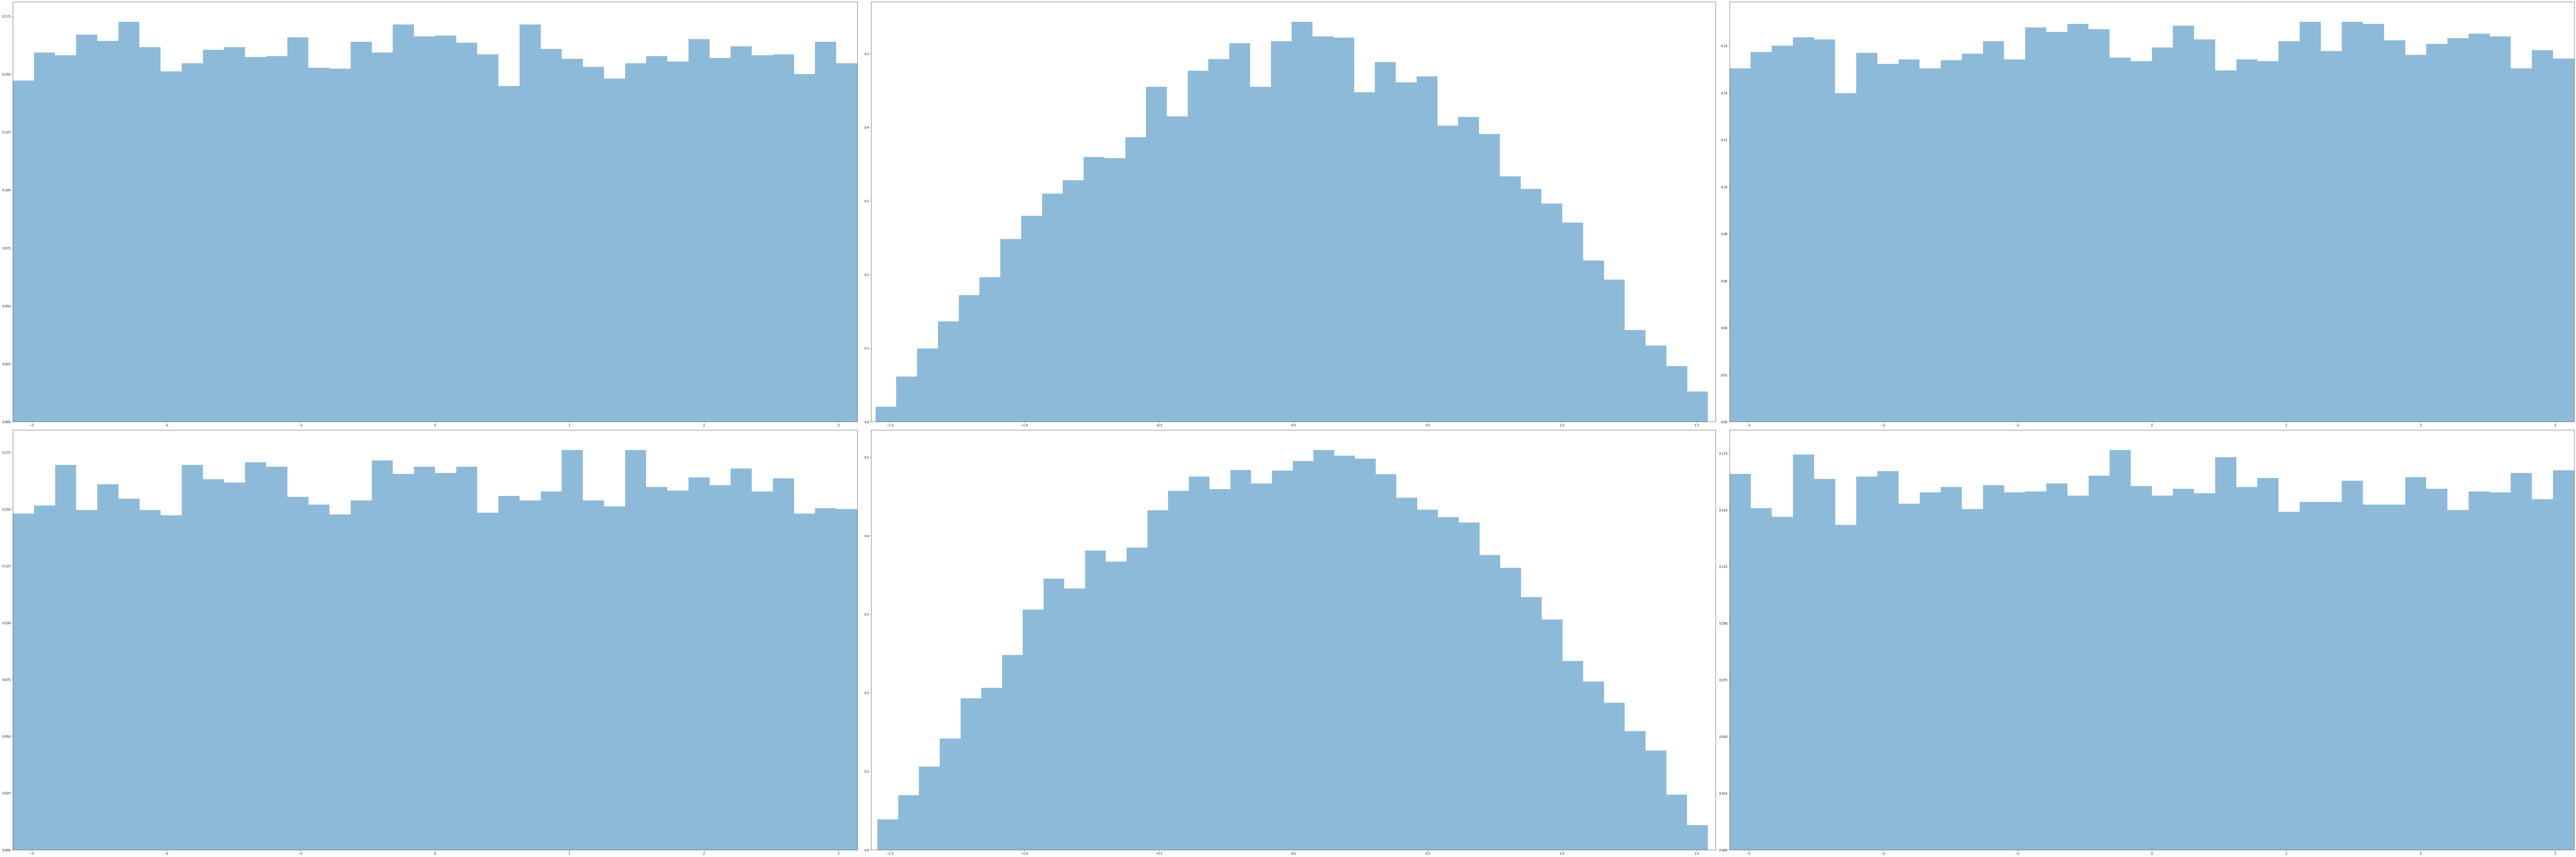

In [6]:
B = 2**14
state = jax.random.PRNGKey(0)

R = sample_unif_scipy(state, 1)
# R = manifold.identity
x0 = sample_unif_scipy(state, B) @ R
x1 = sample_unif_1(state, B) @ R
x2 = sample_unif_2(state, B) @ R
x3 = sample_unif_3(state, B) @ R
xs = [x0, x1, x2, x3]
for x in xs:
    print(x.shape)
    print(manifold.belongs(x, atol=1e-5).mean().item())

# y = next(Uniform(batch_dims=(B), manifold=manifold, seed=0))
# y = jnp.repeat(jnp.expand_dims(manifold.identity, 0), B, axis=0)
# plot_so3(x0, x3, size=40, dpi=300, out="out.jpg", color="red")

In [7]:
# plot_so3(x1, x2, size=40, dpi=300, out="out.jpg", color="red")

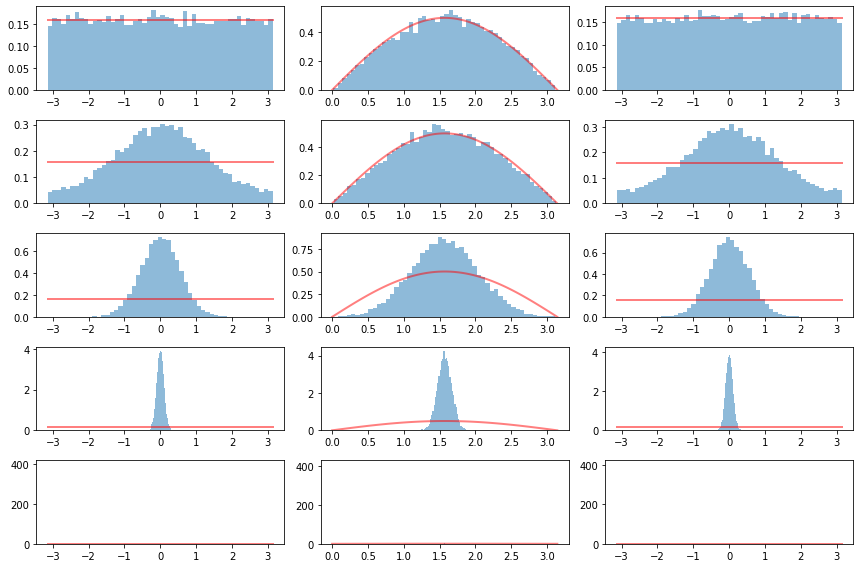

In [8]:

# https://www.jstor.org/stable/2333716
%matplotlib inline

xs = [x0]
for scale in reversed([0.001, 0.1, 0.5, 1.]):
    xw = next(Wrapped(mean=manifold.identity, scale=scale, batch_dims=(B), manifold=manifold, seed=0))
    xs.append(xw)

fig, axes = plt.subplots(len(xs), 3, figsize=(12, 8), sharex=False, sharey=False, tight_layout=True)
n_bins = 50

for i, x in enumerate(xs):
    # w = jnp.linalg.eigvalsh(x)
    # w = _SpecialOrthogonal3Vectors().rotation_vector_from_matrix(x)
    w = _SpecialOrthogonal3Vectors().tait_bryan_angles_from_matrix(x)
    w = np.array(w)
    for j in range(3):
        if j == 0 or j == 2:
            grid = np.linspace(-np.pi, np.pi, 100)
            y = 1 / (2 * np.pi) * np.ones_like(grid)
        else:
            w[:, j] = w[:, j] + math.pi / 2
            # grid = np.linspace(-np.pi/2, np.pi/2, 100)
            grid = np.linspace(0, math.pi, 100)
            y = np.sin(grid) / 2
        # y = np.sin((grid+np.pi/2)/2) ** 2 / (np.pi) * 2
        axes[i, j].plot(grid, y, alpha=0.5, lw=2, color='red')
        axes[i, j].hist(w[:, j], bins=n_bins, density=True, alpha=0.5)

H (16384, 3, 3)
1.0


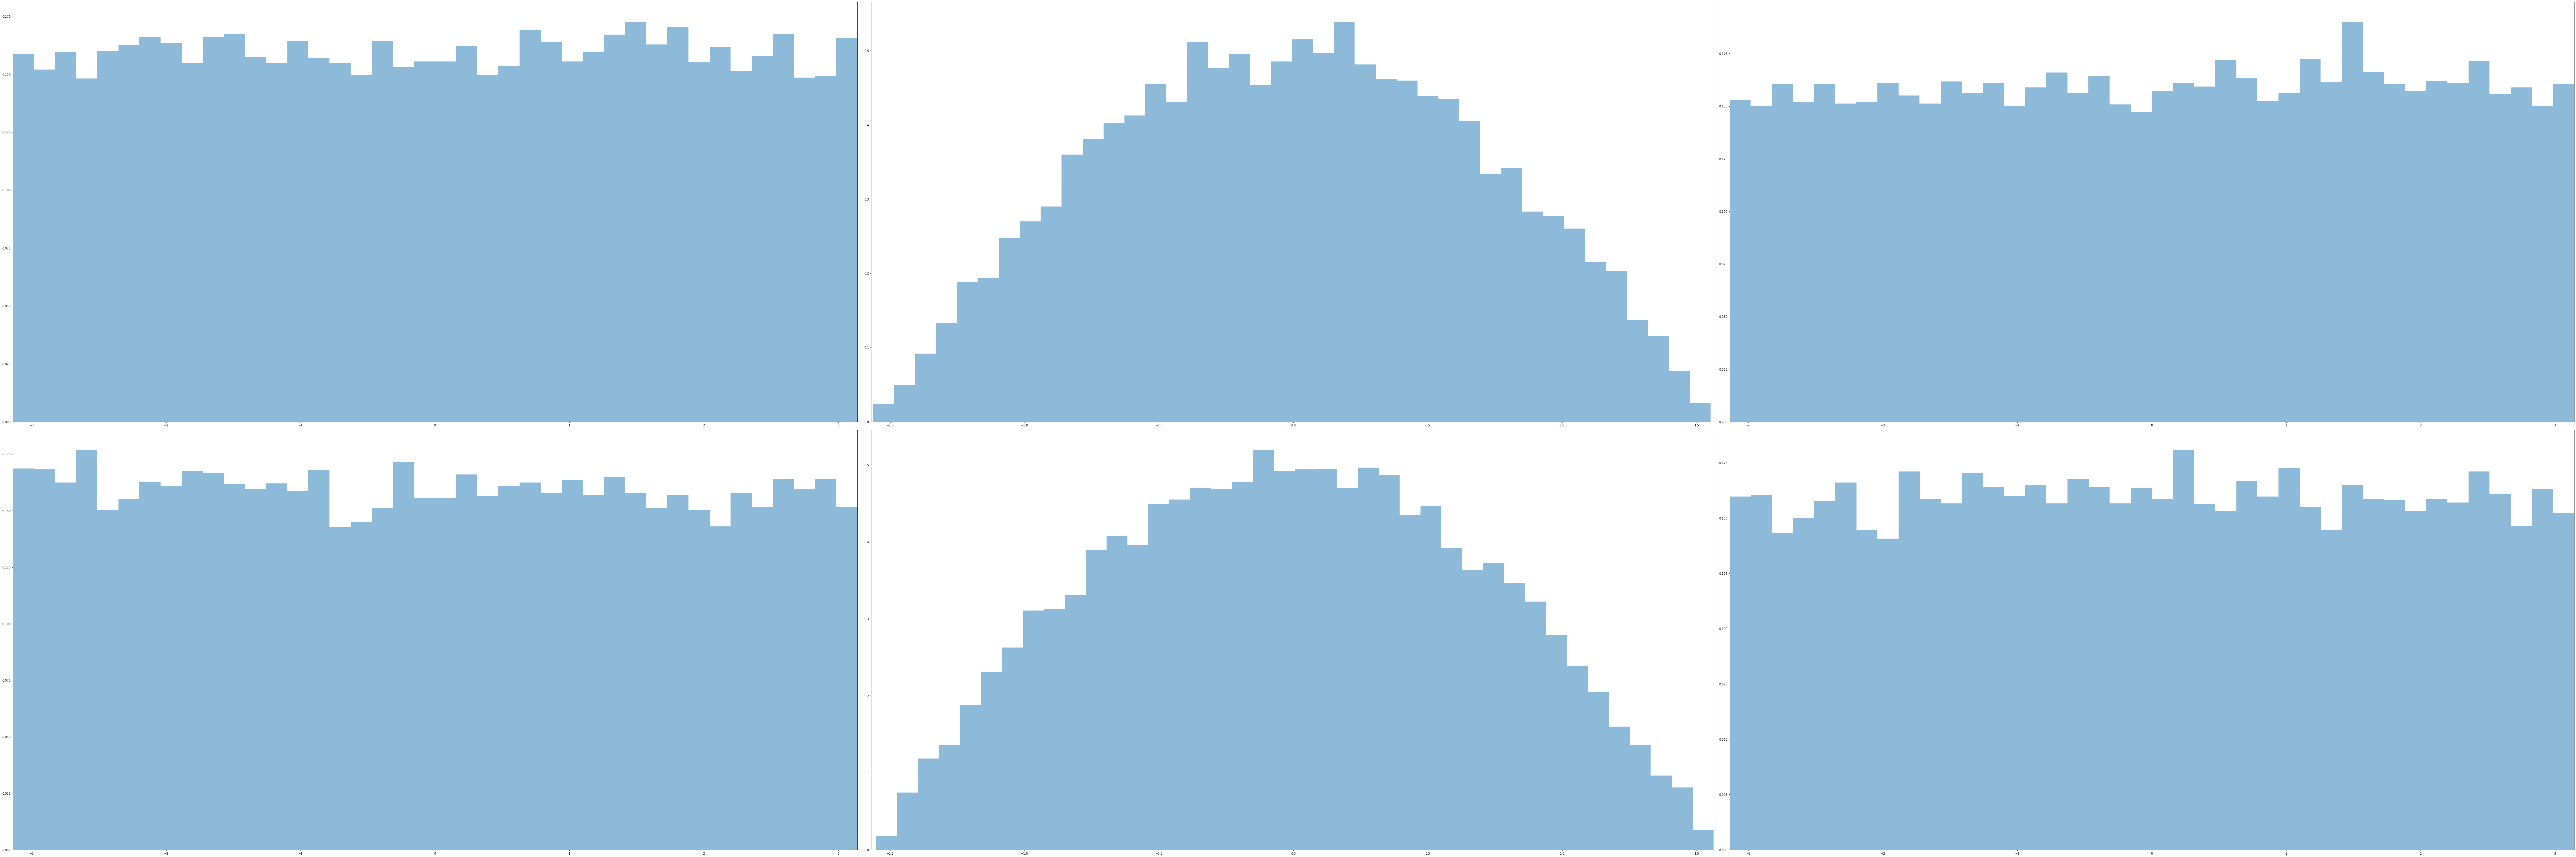

In [9]:
n_samples = 1
n_samples = B
self = manifold
state = jax.random.PRNGKey(3)

dim = self.n
H = gs.repeat(gs.expand_dims(gs.eye(self.n), 0), n_samples, 0)
D = gs.empty((n_samples, self.n))
_, X = gs.random.normal(state=state, size=(n_samples, int((dim-1)*(dim+2)/2)))
idx = 0
for n in range(dim-1):
    # _, x = gs.random.normal(state=next_key, size=(n_samples, dim-n))
    x = X[..., idx:idx+dim-n]
    idx += dim-n
    norm2 = gs.sum(x * x, axis=-1)
    x0 = x[..., 0]
    D = D.at[..., n].set(gs.sign(x[..., 0]))
    x = x.at[..., 0].set(x[..., 0] + D[..., n] * gs.sqrt(norm2))
    denom = gs.sqrt((norm2 - gs.power(x0, 2) + gs.power(x[..., 0], 2)) / 2.)
    x = x / gs.expand_dims(denom, -1)
    # Householder transformation
    H_diff = jax.vmap(lambda H, x: gs.outer(gs.dot(H[:, n:], x), x))(H, x)
    H = H.at[..., n:].set(H[..., n:] - H_diff)
D = D.at[..., -1].set((-1)**(dim-1) * gs.prod(D[..., :-1], -1))
# Equivalent to np.dot(np.diag(D), H) but faster, apparently
# H = gs.transpose(gs.expand_dims(D, -1) * gs.transpose(H, (0, 2, 1)), (0, 2, 1))
H = gs.expand_dims(D, -1) * H
print('H', H.shape)
print(manifold.belongs(H, atol=1e-5).mean().item())

x = special_ortho_group.rvs(3, size=B)
plot_so3(x, H, size=40, dpi=300, out="out.jpg", color="red")

000 -- 100.00 -> 100.00
001 -- 100.00 -> 100.00
002 -- 100.00 -> 100.00
003 -- 100.00 -> 100.00
004 -- 100.00 -> 100.00
005 -- 100.00 -> 100.00
006 -- 100.00 -> 100.00
007 -- 100.00 -> 100.00
008 -- 100.00 -> 100.00
009 -- 100.00 -> 100.00
010 -- 100.00 -> 100.00
011 -- 100.00 -> 100.00
012 -- 100.00 -> 100.00
013 -- 100.00 -> 100.00
014 -- 100.00 -> 100.00
015 -- 100.00 -> 100.00
016 -- 100.00 -> 100.00
017 -- 100.00 -> 100.00
018 -- 100.00 -> 100.00
019 -- 100.00 -> 100.00
020 -- 100.00 -> 100.00
021 -- 100.00 -> 100.00
022 -- 100.00 -> 100.00
023 -- 100.00 -> 100.00
024 -- 100.00 -> 100.00
025 -- 100.00 -> 100.00
026 -- 100.00 -> 100.00
027 -- 100.00 -> 100.00
028 -- 100.00 -> 100.00
029 -- 100.00 -> 100.00
030 -- 100.00 -> 100.00
031 -- 100.00 -> 100.00
032 -- 100.00 -> 100.00
033 -- 100.00 -> 100.00
034 -- 100.00 -> 100.00
035 -- 100.00 -> 100.00
036 -- 100.00 -> 100.00
037 -- 100.00 -> 100.00
038 -- 100.00 -> 100.00
039 -- 100.00 -> 100.00
040 -- 100.00 -> 100.00
041 -- 100.00 ->

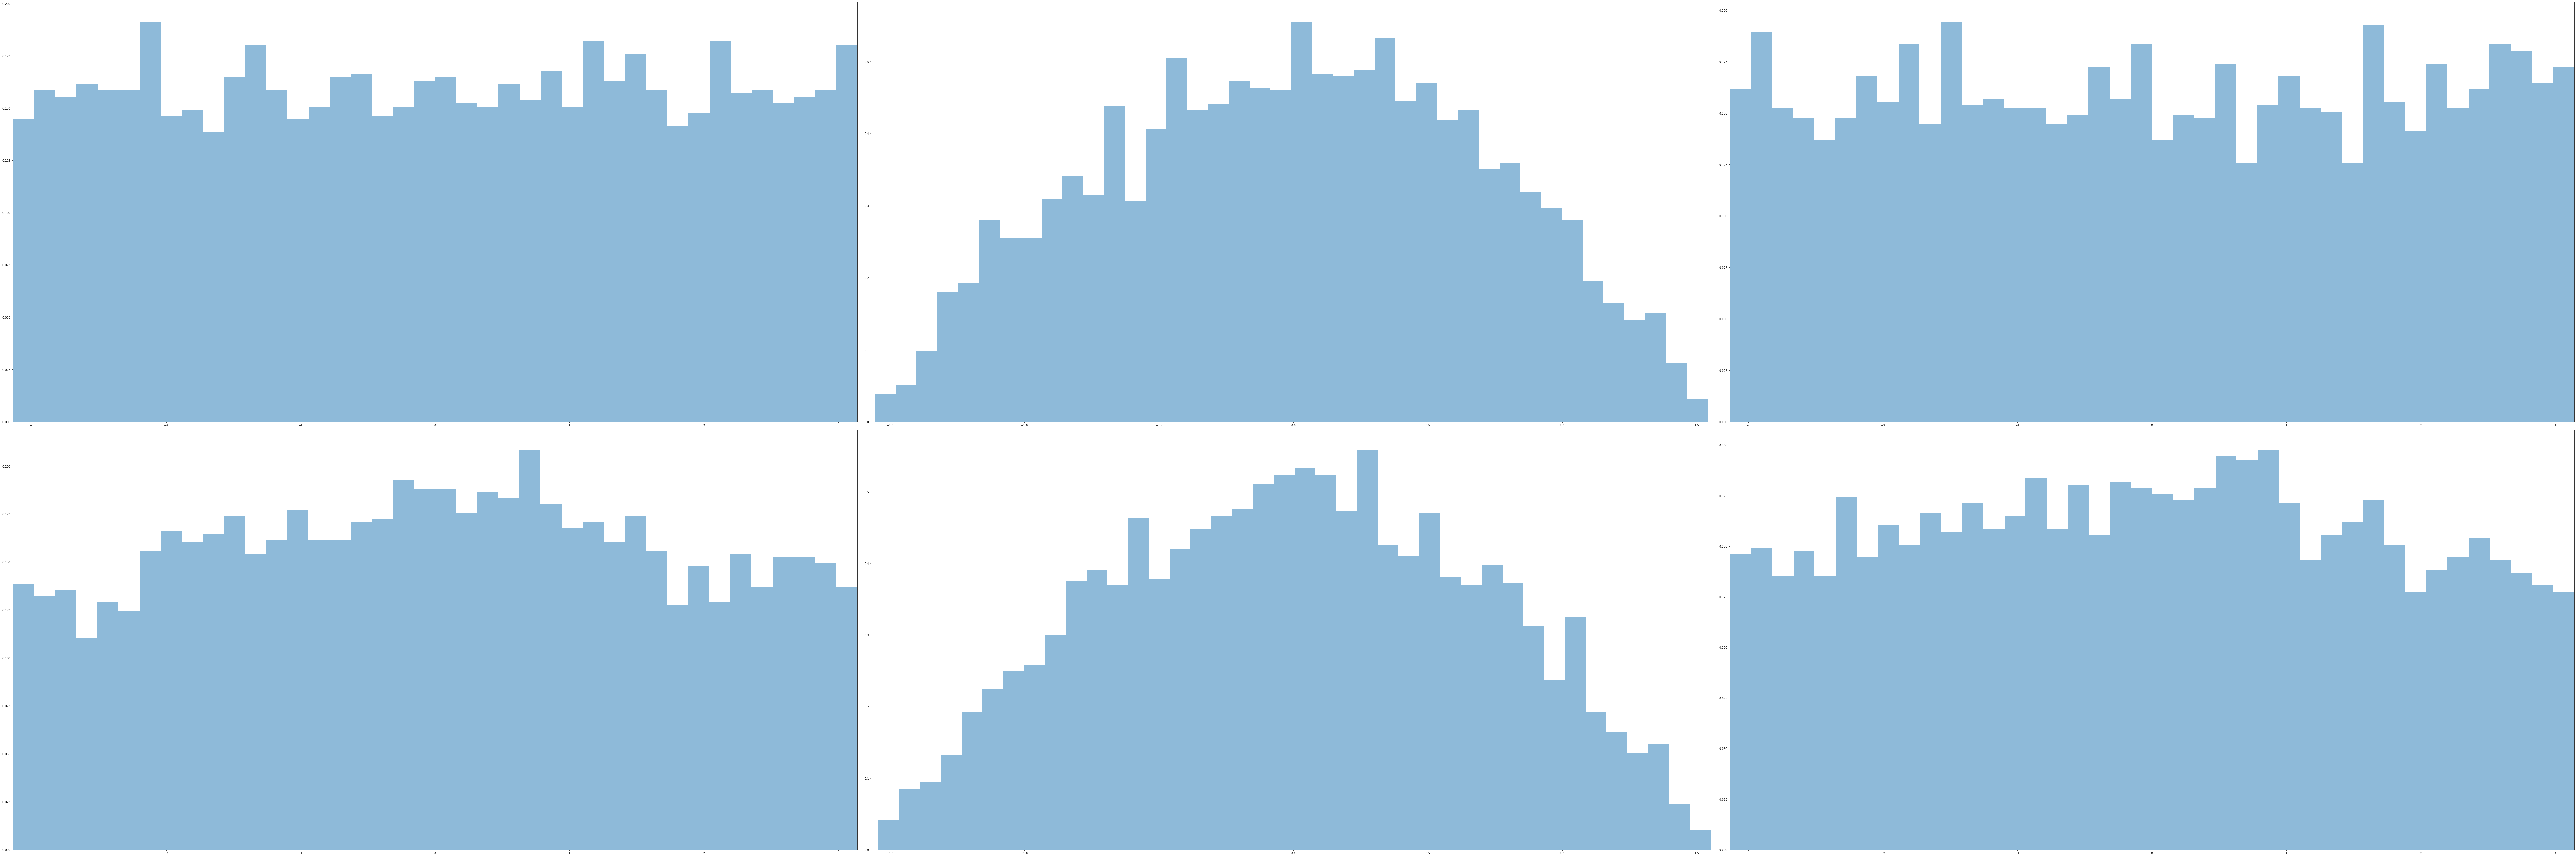

In [10]:
rng = jax.random.PRNGKey(1)

N = 500
B = 2**12
# x = next(Uniform(batch_dims=(B), manifold=manifold, seed=0))
x = gs.repeat(gs.expand_dims(manifold.identity, 0), B, 0)
shape = x.shape

# sde = Brownian(manifold, t0=0, tf=3, beta_0=1, beta_f=1)
sde = Brownian(manifold, t0=0, tf=1, beta_0=0.001, beta_f=5)
dt = (sde.tf - sde.t0) / N * jnp.ones(shape[0])
timesteps = jnp.linspace(start=sde.t0, stop=sde.tf, num=N, endpoint=True)
atol = 1e-5

for i in range(N):
    rng, next_key = jax.random.split(rng)
    z = manifold.random_normal_tangent(state=next_key, base_point=x, n_samples=x.shape[0])[1].reshape(shape[0], -1)
    # drift = jnp.zeros(shape).reshape(shape[0], -1)
    # diffusion = jnp.ones(shape[0])
    t = timesteps[i]
    drift, diffusion = sde.coefficients(x.reshape(shape[0], -1), t)
    # diffusion = diffusion * 0.1
    drift = drift * dt[..., None]
    tangent_vector = drift + jnp.einsum(
                "...,...i,...->...i", diffusion, z, jnp.sqrt(jnp.abs(dt))
            )
    tangent_vector = tangent_vector.reshape(shape)
    tangent_vector = manifold.to_tangent(tangent_vector, x)
    belong_v = manifold.is_tangent(tangent_vector, x, atol=atol).mean().item()
    x = manifold.exp(tangent_vec=tangent_vector, base_point=x)

    # tangent_vector = manifold.compose(manifold.inverse(x), tangent_vector)
    # # tangent_vector = manifold.to_tangent(tangent_vector)
    # belong_v2 = manifold.lie_algebra.belongs(tangent_vector, atol=atol).mean().item()
    # # x = manifold.compose(x, gs.linalg.expm(tangent_vector))
    # x = manifold.compose(x, manifold.exp_from_identity(tangent_vector))
    # # x = manifold.projection(x)
    belong_x = manifold.belongs(x, atol=atol).mean().item()
    if i >= 0:
        print(f"{i:03d} -- {100*belong_v:.2f} -> {100*belong_x:.2f}")

y = special_ortho_group.rvs(3, size=B)
plot_so3(y, x, size=40, dpi=300, out="out.jpg", color="red")

In [26]:
B = 2

key, next_key = jax.random.split(state)
x_t = sample_unif_scipy(next_key, B)
key, next_key = jax.random.split(state)
score = manifold.log(sample_unif_scipy(next_key, B), x_t)

sq_norm_score = manifold.metric.squared_norm(score, x_t)
print(sq_norm_score)
sq_norm_score = gs.einsum("...ij,...ij->...", score, score)
print(sq_norm_score)
sq_norm_score = gs.sum(gs.power(score.reshape(B, -1), 2), axis=-1)
print(sq_norm_score)
sq_norm_score = gs.trace(score @ gs.transpose(score, (0, 2, 1)), axis1=-2, axis2=-1)
print(sq_norm_score)
sq_norm_score = gs.sum(gs.power(manifold.vector_from_skew_matrix(score), 2), axis=-1)
print(sq_norm_score)

[14.630303 18.615473]
[14.630303 18.615473]
[14.630303 18.615473]
[14.630304 18.615473]
[4.6014676 2.4346483]
